In this project, we tested aggregation rules on approval votes from real world participatory budgeting elections. Specifically, we use data from Pubulib, which consists of real world approval votes from city elections.

In [2]:
import csv
from itertools import chain, combinations
import matplotlib.pyplot as plt

Helper functions define below. `parser` parses participatory budgeting data from Pubulib.

In [3]:
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))

def parser(path):
    with open(path, 'r', newline='', encoding="utf-8") as csvfile:
        meta = {}
        projects = {}
        votes = []
        section = ""
        header = []
        reader = csv.reader(csvfile, delimiter=';')
        for row in reader:
            if str(row[0]).strip().lower() in ["meta", "projects", "votes"]:
                section = str(row[0]).strip().lower()
                header = next(reader)
            elif section == "meta":
                meta[row[0]] = row[1].strip()
            elif section == "projects":
                projects[row[0]] = {}
                for it, key in enumerate(header[1:]):
                    projects[row[0]][key.strip()] = row[it+1].strip()
            elif section == "votes":
                votes.append({})
                for it, key in enumerate(header[1:]):
                    votes[-1][key.strip()] = row[it+1].strip()
                votes[-1]['vote'] = votes[-1]['vote'].split(',')
                votes[-1]['vote'] = set([v for v in votes[-1]['vote']])
        items = projects.keys()
        max_cost = float(meta['budget'])
        costs = {}
        for item in items:
            costs[item] = float(projects[item]['cost'])
        return votes, items, costs, max_cost


We then implement the 3 satisfaction functions defined in Faliszewski et al. For a budget $B$ and a voter $v$ with their approval set $A_v$, let $B_v := A_v ∩ B$. They are defined as follows:
1. $ f(A_v, B) = |B_v| $ Satisfaction here is the number of items in the budget that the voter approves of
2. $ f(A_v, B) = \sum_{a∈B_v} c(a) = c(Bv) $ Satisfaction here is the total cost of items in the budget that the voter approves of
3. $ f(A_v, B) = 1_{|B_v| > 0}$ Satisfaction here is binary where the satisfaction is 1 if at least one of the voter's approved items are in the budget and 0 otherwise.

In [4]:
def num_satisfaction(budget, voter, costs):
    return len(budget.intersection(voter['vote']))

def cost_satisfaction(budget, voter, costs):
    covered = budget.intersection(voter['vote'])
    return total_cost(covered, costs)

def binary_satisfaction(budget, voter, costs):
    return num_satisfaction(budget, voter, costs) > 0

We then implement the 3 voter aggregation rules defined in Faliszewski et al.
1. Max rules: Selects the budget as the subset of all items that receives the highest satisfaction score as mentioned above.
2. Greedy rules: For a satisfaction function $f$, the rule proceeds in iterations, maintaining a partial budget $B$, where in each iteration it adds an item a to B which maximizes the value $\sum_{v∈V} f(A_v, B ∪ {a})$
3. For a satisfaction function $f$, the rule proceeds in iterations, maintaining a partial budget $B$, where in each iteration it adds an item a to B which maximizes the value $(\sum_{v∈V} f(A_v, B ∪ {a}) - \sum_{v∈V} f(A_v, B)) / c(a)$ where $c(a)$ is the cost of the item.



In [37]:
def total_cost(budget, costs):
    cost = 0
    for it in budget:
        cost += costs[it]
    return cost

def max_rule(items, voters, costs, max_cost, satisfaction_fn):
    subsets = all_subsets(items)
    best_set = set([])
    max_score = 0
    for budget in subsets:
        if (total_cost(budget, costs) > max_cost):
            continue
        score = sum([satisfaction_fn(set(budget), v, costs) for v in voters])
        if score > max_score:
            max_score = score
            best_set = budget
    return set(best_set)

def greedy_rule(items, voters, costs, max_cost, satisfaction_fn):
    cur_budget = set([])
    cur_cost = 0
    items_set = set(items)
    while (cur_cost < max_cost):
        best_item = None
        best_score = 0
        for it in items:
            if(costs[it] + cur_cost > max_cost or it in cur_budget):
                continue
            score = sum([satisfaction_fn(cur_budget | set([it]), v, costs) for v in voters])
            if (score >= best_score):
                best_score = score
                best_item = it
        if not best_item:
            break
        cur_budget.add(best_item)
        cur_cost += costs[best_item]
    return cur_budget

def prop_greedy_rule(items, voters, costs, max_cost, satisfaction_fn):
    cur_budget = set([])
    cur_cost = 0
    cur_score = 0
    items_set = set(items)
    while (cur_cost < max_cost):
        best_item = None
        best_score = 0
        best_norm_score = 0
        for it in items:
            if(costs[it] + cur_cost > max_cost or it in cur_budget):
                continue
            score = sum([satisfaction_fn(cur_budget | set([it]), v, costs) for v in voters])
            norm_score = (score - cur_score) / costs[it]
            if (norm_score >= best_norm_score):
                best_score = score
                best_norm_score = norm_score
                best_item = it
        if not best_item:
            break
        cur_budget.add(best_item)
        cur_score = best_score
        cur_cost += costs[best_item]
    return cur_budget

We then define the metric functions we intend to use for testing on Pubulib data. Specifically, we consider voter anger which is defined as the fraction of voters who are ignored in the election and the average cost of the budget.

In [39]:
def anger_ratio(voters, budget):
    total_anger = sum([binary_satisfaction(budget, v, None) == 0 for v in voters])
    return total_anger / len(voters)

def ave_cost(budget, costs):
    total_cost = sum([costs[it] for it in budget])
    return total_cost / len(budget)

In [ ]:
votes, items, costs, max_cost = parser('poland_warszawa_2019_nadwisle.pb')
print(total_cost(items, costs))
print("GREEDY NUM_SAT")
budget = greedy_rule(items, votes, costs, max_cost, num_satisfaction)
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("GREEDY COST_SAT")
budget = greedy_rule(items, votes, costs, max_cost, cost_satisfaction)
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("GREEDY BIN_SAT")
budget = greedy_rule(items, votes, costs, max_cost, binary_satisfaction)
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("PROP GREEDY NUM_SAT")
print(prop_greedy_rule(items, votes, costs, max_cost, num_satisfaction))
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("PROP GREEDY COST_SAT")
print(prop_greedy_rule(items, votes, costs, max_cost, cost_satisfaction))
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("PROP GREEDY BIN_SAT")
print(prop_greedy_rule(items, votes, costs, max_cost, binary_satisfaction))
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("MAX NUM_SAT")
budget = set(max_rule(items, votes, costs, max_cost, num_satisfaction))
print(budget)
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("MAX COST_SAT")
budget = set(max_rule(items, votes, costs, max_cost, num_satisfaction))
print(budget)
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

print("----")
print("MAX BIN_SAT")
budget = set(max_rule(items, votes, costs, max_cost, num_satisfaction))
print(budget)
print("ANGER: ", anger_ratio(votes, budget))
print("AVE COST: ", ave_cost(budget, costs))

# Analysis

Greedy: Using the greedy aggregation rule defined above we evaluate it's performance on a sampled real world dataset using each of the satisfaction functions.

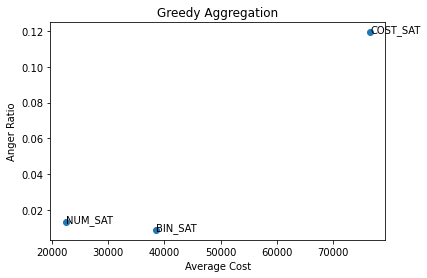

In [ ]:
# Greedy Aggregation Rule
anger = []
cost = []
votes, items, costs, max_cost = parser('poland_warszawa_2019_siekierki-augustowka.pb')
annotations=["NUM_SAT","BIN_SAT","COST_SAT"]

budget = greedy_rule(items, votes, costs, max_cost, num_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))

budget = greedy_rule(items, votes, costs, max_cost, binary_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


budget = greedy_rule(items, votes, costs, max_cost, cost_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


plt.scatter(cost, anger)
plt.xlabel("Average Cost")
plt.ylabel("Anger Ratio")
plt.title("Greedy Aggregation")
for i, label in enumerate(annotations):
    plt.annotate(label, (cost[i], anger[i]))


We see here using the greedy aggregation that the number satisfaction function performs the best with the lowest average cost and anger ratio, while the cost satisfaction method has the greatest cost and anger ratio. The high anger ratio means a greater proportion of voters who were ignored in this election.

# Prop Greedy Aggregation

Text(0.5, 1.0, 'Prop Greedy Aggregation')

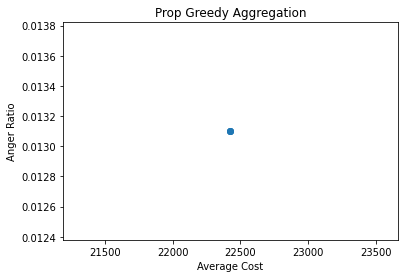

In [25]:
# Prop Greedy Aggregation Rule
anger = []
cost = []
votes, items, costs, max_cost = parser('poland_warszawa_2019_siekierki-augustowka.pb')
annotations=["NUM_SAT","BIN_SAT","COST_SAT"]

budget = prop_greedy_rule(items, votes, costs, max_cost, num_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))

budget = prop_greedy_rule(items, votes, costs, max_cost, binary_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


budget = prop_greedy_rule(items, votes, costs, max_cost, cost_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


plt.scatter(cost, anger)
plt.xlabel("Average Cost")
plt.ylabel("Anger Ratio")
plt.title("Prop Greedy Aggregation")



We see here that the all satisfaction functions produce the same result for the prop greedy aggregation method. This could be because of the normalization parameter.


# Max Aggregation

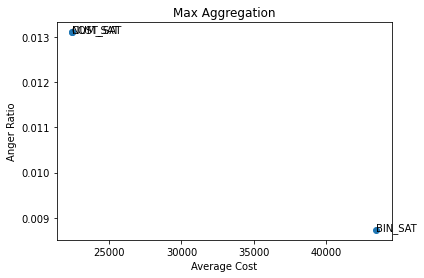

In [49]:
# Max Aggregation Rule
anger = []
cost = []
votes, items, costs, max_cost = parser('poland_warszawa_2019_siekierki-augustowka.pb')
annotations=["NUM_SAT","BIN_SAT","COST_SAT"]

budget = max_rule(items, votes, costs, max_cost, num_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))

budget = max_rule(items, votes, costs, max_cost, binary_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


budget = max_rule(items, votes, costs, max_cost, cost_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


plt.scatter(cost, anger)
plt.xlabel("Average Cost")
plt.ylabel("Anger Ratio")
plt.title("Max Aggregation")
for i, label in enumerate(annotations):
    plt.annotate(label, (cost[i], anger[i]))


Here we see that the binary satisfaction has a significantly lower anger ratio but the cost is much higher. The num sat and cost sat have much higher anger ratios but lower average costs. This is most likely because the binary method combined with max aggregation simply chooses the profile where the most amount of voters had one item in.

# Second Example

# Greedy

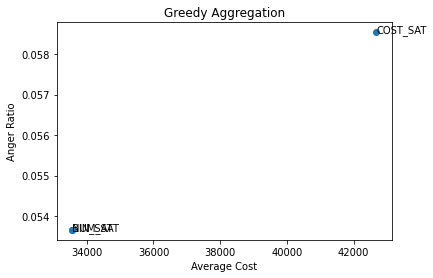

In [48]:
# Greedy Aggregation Rule
anger = []
cost = []
votes, items, costs, max_cost = parser('poland_warszawa_2019_nadwisle.pb')
annotations=["NUM_SAT","BIN_SAT","COST_SAT"]

budget = greedy_rule(items, votes, costs, max_cost, num_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))

budget = greedy_rule(items, votes, costs, max_cost, binary_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


budget = greedy_rule(items, votes, costs, max_cost, cost_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


plt.scatter(cost, anger)
plt.xlabel("Average Cost")
plt.ylabel("Anger Ratio")
plt.title("Greedy Aggregation")
for i, label in enumerate(annotations):
    plt.annotate(label, (cost[i], anger[i]))


Here we see that the cost satisfaction rule performs poorly, which is consistent with the previous example. This difference arises because unlike the other two satisfaction functions, cost satisfaction is based on budget cost rather than the amount of chosed items.

# Prop Greedy Aggregation

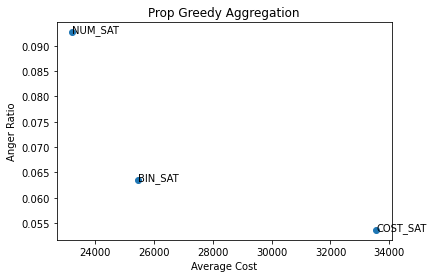

In [51]:
# Prop Greedy Aggregation Rule
anger = []
cost = []
votes, items, costs, max_cost = parser('poland_warszawa_2019_nadwisle.pb')
annotations=["NUM_SAT","BIN_SAT","COST_SAT"]

budget = prop_greedy_rule(items, votes, costs, max_cost, num_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))

budget = prop_greedy_rule(items, votes, costs, max_cost, binary_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


budget = prop_greedy_rule(items, votes, costs, max_cost, cost_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


plt.scatter(cost, anger)
plt.xlabel("Average Cost")
plt.ylabel("Anger Ratio")
plt.title("Prop Greedy Aggregation")
for i, label in enumerate(annotations):
    plt.annotate(label, (cost[i], anger[i]))



There are some interesting results here. Using the normalized greedy aggregation we have pretty spread out results unlike in the Prop Greedy of the previous example. Binary satisfaction thus seems to perform the best here as it has a good balance between anger ratio and average cost.

#Max Aggregation

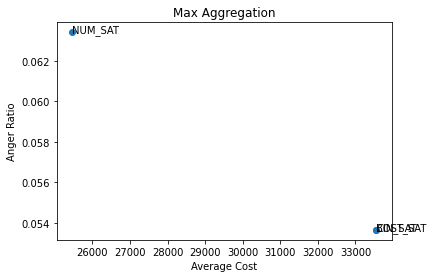

In [52]:
# Max Aggregation Rule
anger = []
cost = []
votes, items, costs, max_cost = parser('poland_warszawa_2019_nadwisle.pb')
annotations=["NUM_SAT","BIN_SAT","COST_SAT"]

budget = max_rule(items, votes, costs, max_cost, num_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))

budget = max_rule(items, votes, costs, max_cost, binary_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


budget = max_rule(items, votes, costs, max_cost, cost_satisfaction)
anger.append(anger_ratio(votes, budget))
cost.append(ave_cost(budget, costs))


plt.scatter(cost, anger)
plt.xlabel("Average Cost")
plt.ylabel("Anger Ratio")
plt.title("Max Aggregation")
for i, label in enumerate(annotations):
    plt.annotate(label, (cost[i], anger[i]))

Here the cost satisfaction has moved closer towards the binary satisfaction. Once again the cost seems to have moved here because cost satisfaction focuses on total cost vs number of items. The fact that it follows closely to binary satisfaction shows there might be some item that was very popular and had a significant cost.

# Conclusion

From the first example we saw that the greedy aggregation performed the best with the lowest anger ratio and budget cost. However, that result is most likely a function of our chosen metrics. In this study we chose to focus on anger ratio and cost as our metric of evaluation, others might prefer different metrics of evaluation. That topic is also one of great importance and should be considered. 

From the second example it's a little more unclear which aggregation method and satisfaction function should be chosen. There are some options that have a clear advantage in cost but high anger ratio and vice versa but none that are clearly better than the rest. We believe this will require a decision on how much each point of happiness is worth monetarily. If the average budget is below what the city planned to spend then optimizing for the lowest anger ratio would be best, but in the real world many times budget constraints are very close to the average cost. 

Future work should be done to apply these methods to more real world data sets to see how theoretical models really perform. 